# Linear Regression Implementation from Scratch

We will implement the entire method from scratch, including the data pipeline, the model, the loss function, and the minibatch stochastic gradient descent optimizer.

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import random

## Generating the Dataset

We generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

You could think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01.

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.3835,  1.2213]) 
label: tensor([-0.7296])


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,

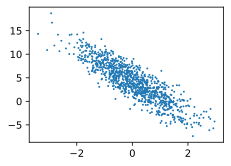

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1)

## Reading the Dataset

Recall that training models consists of
making multiple passes over the dataset,
grabbing one minibatch of examples at a time,
and using them to update our model.

We define a utility function
to shuffle the dataset and access it in minibatches.

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5551,  1.2707],
        [ 0.7141,  0.4700],
        [-0.2616,  0.8160],
        [ 1.3633, -0.0785],
        [-0.0299, -0.0426],
        [ 0.1483,  0.8234],
        [-0.7034,  0.8516],
        [ 0.4248,  0.8656],
        [-0.8474,  0.0079],
        [-0.5636, -0.9365]]) 
 tensor([[ 0.9779],
        [ 4.0367],
        [ 0.9263],
        [ 7.1871],
        [ 4.3035],
        [ 1.7018],
        [-0.1027],
        [ 2.1068],
        [ 2.4881],
        [ 6.2705]])


## Initializing Model Parameters

Before we can begin optimizing our model's parameters by minibatch stochastic gradient descent,
we need to have some parameters in the first place.

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

After initializing our parameters,
our next task is to update them until
they fit our data sufficiently well.
Each update requires taking the gradient
of our loss function with respect to the parameters.
Given this gradient, we can update each parameter
in the direction that may reduce the loss.

## Defining the Model

Next, we must define our model,
relating its inputs and parameters to its outputs.
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.

In [8]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

## Defining the Loss Function

Since updating our model requires taking
the gradient of our loss function,
we ought to define the loss function first.
Here we will use the squared loss function.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.

In [9]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

The following code applies the minibatch stochastic gradient descent update,
given a set of parameters, a learning rate, and a batch size.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the minibatch of examples,
we normalize our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.

In [10]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

Now that we have all of the parts in place,
we are ready to implement the main training loop.

In each iteration, we will grab a minibatch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will call the optimization algorithm `sgd`
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
    
In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters,
which we set here to 3 and 0.03, respectively. Unfortunately, setting hyperparameters is tricky
and requires some adjustment by trial and error.

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037249
epoch 2, loss 0.000139
epoch 3, loss 0.000054


We can evaluate our success in training
by comparing the true parameters
with those that we learned through our training loop.

In [12]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-4.2510e-04, -1.7643e-05], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0005], grad_fn=<RsubBackward1>)


Note that we should not take it for granted
that we are able to recover the parameters perfectly.
However, in machine learning, we are typically less concerned
with recovering true underlying parameters,
and more concerned with parameters that lead to highly accurate prediction.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.

## Summary

* We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.
* This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.

## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work?
1. Assume that you are
   [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model between voltage and current. Can you use auto differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density?
1. What are the problems you might encounter if you wanted to  compute the second derivatives? How would you fix them?
1.  Why is the `reshape` function needed in the `squared_loss` function?
1. Experiment using different learning rates to find out how fast the loss function value drops.
1. If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?